# Neural Collapse and Data Distillatioin

This notebook implements an advanced data distillation algorithm utilizing the recent finding in neural collapse. 

The main papers considered here are 
 - data distillation:
     - https://github.com/SsnL/dataset-distillation 
     - https://github.com/google-research/google-research/tree/master/kip
 - Neural Collapse:
     - https://github.com/tding1/Neural-Collapse. 

The neural network has fixed the last layer weight matrix to be a simplex ETF. The ETF is a benign optimization landscape empeirically observed in practice as long as the network enters its terminal phase.

Below we configure our path to the dataset distillation packages from https://github.com/SsnL/dataset-distillation.

# Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, MNIST
from torch.utils.data import DataLoader, Dataset
import numpy as np
import copy
from contextlib import contextmanager

from six import add_metaclass
from typing import Type, Any, Callable, Union, List, Optional

Let's import the file from the https://github.com/tding1/Neural-Collapse.

In [3]:
import models
from models import resnet_decode
from models.res_adapt import ResNet18_adapt
from utils import *

from train_Encoder import train
from validate_NC import *

from validate_NC import compute_Wh_b_relation, compute_W_H_relation, compute_ETF, compute_Sigma_B, compute_Sigma_W,compute_info,FCFeatures
from data.datasets import make_dataset
from data.data_loading import get_cifar10_data_loaders
from arg_loader import *
import time

# Load Parameters

In [13]:
# architecture params
model='resnet18'

# dataset
dataset='mnist'
data_dir='~/data'

# training params
epochs = 1
optimizer="LBFGS"
lr=0.1
history_size=10
batch_size=1024
uid="tmp19"
SOTA=False

# Network params
loss = 'CrossEntropy'
bias=True
#######################
"""
Here, we plug in the ETF to our model
"""
ETF_fc=True
#######################
fixdim=0

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:"+str(gpu_id))
    device_name = torch.cuda.get_device_name(0)
    # 
    torch.cuda.empty_cache()
    if check:
        torch.cuda.memory_allocated()
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple Silicon GPU"
else:
    device = torch.device("cpu")
    device_name = "CPU"

print(f"Using device: {device}, {device_name}")

Using device: mps, Apple Silicon GPU


In [14]:
args = args(model=model, dataset=dataset, optimizer=optimizer, lr = lr, loss = loss,
            history_size=history_size, batch_size = batch_size, epochs=1,
            uid = uid, device = device)

# Load Dataset

Let's load the dataset from some externel sources. To do the data distillation on the machine, we need to find a way to:

- Randomly generate data to distill, which require gradients.
- Combined the generated data with our training data.
- Start to training the neural network (run the data distillation algorithm)
- Extract the distilled data from the training data and investigate it.

In [7]:
from torchvision.datasets import CIFAR10, MNIST

trainset = MNIST(root='mnist', train=True, download=True, transform=transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ]))

testset = MNIST(root='mnist', train=False, download=True, transform=transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ]))

100%|████████████████████████████| 9912422/9912422 [00:06<00:00, 1621382.65it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|████████████████████████████████| 28881/28881 [00:00<00:00, 2432248.29it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|████████████████████████████| 1648877/1648877 [00:01<00:00, 1437421.99it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 3952391.86it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [11]:
type(trainset)

torchvision.datasets.mnist.MNIST

<class 'torch.Tensor'>


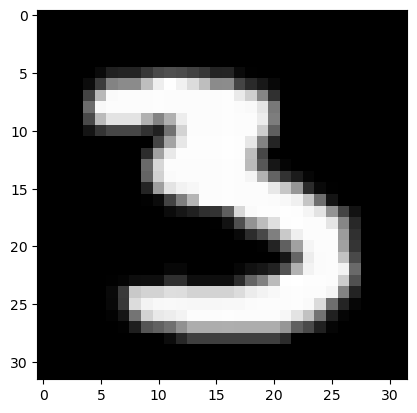

In [12]:
import matplotlib.pyplot as plt

x, _ = trainset[47802]
print(type(x))
plt.imshow(x.numpy()[0], cmap='gray')

In [14]:
trainset = CIFAR10(root=data_dir, train=True, download=True, transform=transforms.Compose([
                transforms.RandomCrop(size=32, padding=4),
                transforms.RandomHorizontalFlip(p=0.5),

                transforms.ToTensor(),
                transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
                ]))

Files already downloaded and verified


In [15]:
trainset = CIFAR10(root=data_dir, train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    ]))

testset = CIFAR10(root=data_dir, train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    ]))

Files already downloaded and verified
Files already downloaded and verified


In [16]:
type(trainset)

torchvision.datasets.cifar.CIFAR10

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


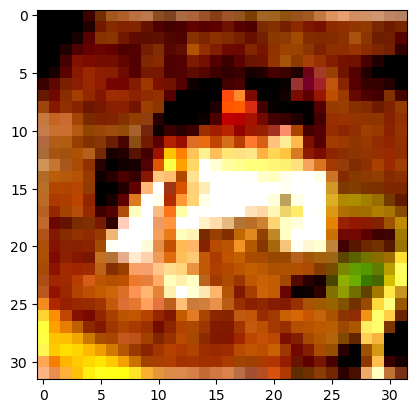

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


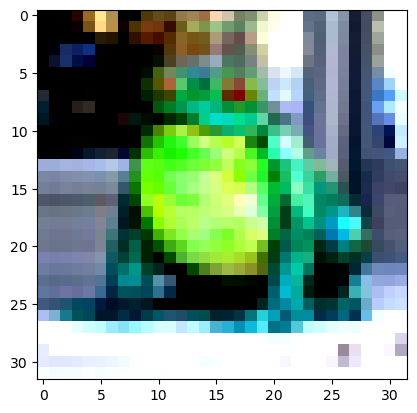

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


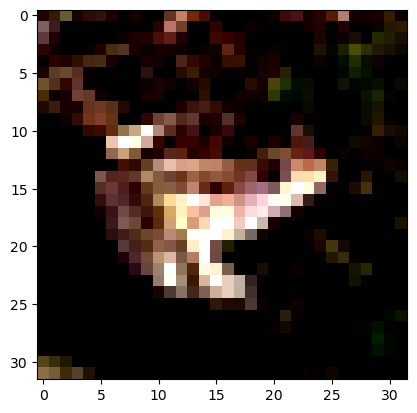

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


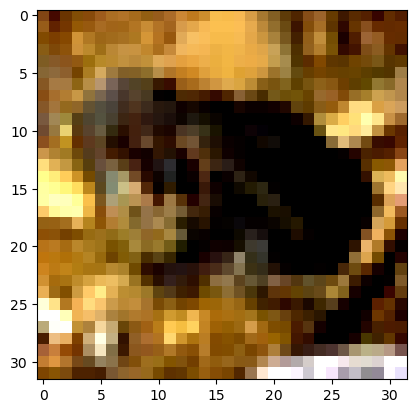

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


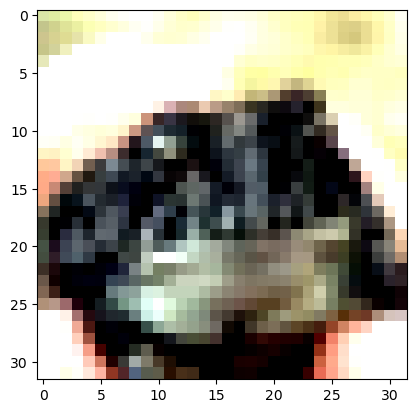

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


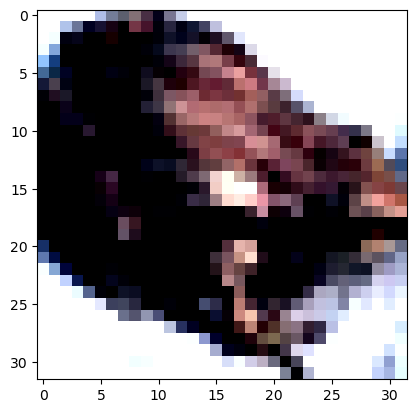

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


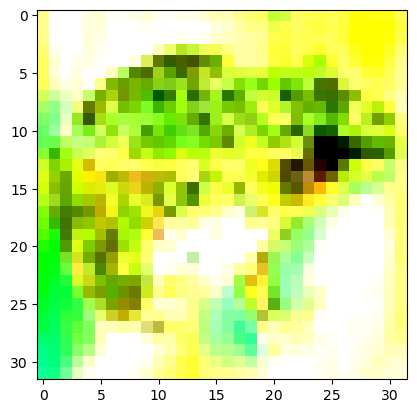

In [18]:
# show_cifar.py
# Python 3.7.6  PyTorch 1.6.0  TorchVision 0.7.0

import torch as T
import torchvision as tv
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5   # unnormalize
    npimg = img.numpy()   # convert from tensor
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()


trainset = CIFAR10(root=data_dir, train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    ]))
trainloader = T.utils.data.DataLoader(trainset,
                                      batch_size=100, shuffle=False, num_workers=1)

# Check if trainloader is loaded
if trainloader is None:
    raise ValueError("Trainloader is not loaded. Please load it before running this script.")

dataiter = iter(trainloader)
imgs, lbls = next(dataiter)
for i in range(100):  # show just the frogs
    if lbls[i] == 6:  # 6 = frog
        imshow(tv.utils.make_grid(imgs[i]))


In [19]:
trainloader, _, num_classes = make_dataset(dataset, 
                                           data_dir, 
                                           batch_size, 
                                           SOTA=SOTA)
print(trainloader)

Dataset: MNIST.


In [20]:
images, labels = next(iter(trainloader))
size_train, channels, height, width = images.shape
nc = channels
input_size = height, width
print("The number of class in our training set is ", num_classes)
print("Batch size:", size_train, 
      ", Number of channels:", channels, 
      ", input height:", height, 
      ", input width:", width)

The number of class in our training set is  10
Batch size: 1024 , Number of channels: 3 , input height: 32 , input width: 32


In [21]:
def generate_distilled_images(train_dataset, num_images_per_class, image_shape, device):
    """
    Generates distilled images with gradients enabled, using labels from the training dataset.

    Parameters:
    - train_dataset: The training dataset to extract label information.
    - num_images_per_class: Number of distilled images to generate per class.
    - image_shape: Tuple (channels, height, width) representing the shape of the images.
    - device: The device to generate the images on ('cpu' or 'cuda').

    Returns:
    - A tuple of two PyTorch tensors:
      1. Tensor containing the distilled images with gradients enabled.
      2. Tensor containing the corresponding labels for each image.
    """
    # Extract unique labels from the training dataset
    unique_labels = list(set(train_dataset.targets))
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

    distilled_images = []
    labels = []

    for label in unique_labels:
        # Generate random images for this label
        images = torch.randn(num_images_per_class, *image_shape, requires_grad=True).to(device)
        distilled_images.append(images)

        # Assign labels based on the training dataset
        labels += [label_to_index[label]] * num_images_per_class

    # Concatenate all images and labels into single tensors
    distilled_tensor = torch.cat(distilled_images, dim=0)
    labels_tensor = torch.tensor(labels, dtype=torch.long).to(device)

    return distilled_tensor, labels_tensor


In [22]:
def generate_distilled_dataset(trainloader, num_images_per_class, device):
    images, labels = next(iter(trainloader))
    _, channels, height, width = images.shape
    num_classes = len(torch.unique(labels))

    distilled_data, distilled_labels = generate_distilled_images(
        trainloader.dataset, num_images_per_class, (channels, height, width), device
    )

    return distilled_data, distilled_labels

In [23]:
distilled_data, distilled_labels = generate_distilled_dataset(trainloader, 
                                                              num_images_per_class = 1, 
                                                              device = "cpu")


In [24]:
type(distilled_labels)

torch.Tensor

In [25]:
import torch
from torch.utils.data import Dataset

class CombinedDataset(Dataset):
    def __init__(self, original_dataset, distilled_images, distilled_labels):
        self.original_dataset = original_dataset
        self.distilled_images = distilled_images
        self.distilled_labels = distilled_labels
        self.distilled_start_index = len(self.original_dataset)

    def __len__(self):
        return len(self.original_dataset) + len(self.distilled_images)

    def __getitem__(self, idx):
        if idx < self.distilled_start_index:
            return self.original_dataset[idx]
        else:
            distilled_idx = idx - self.distilled_start_index
            return self.distilled_images[distilled_idx], self.distilled_labels[distilled_idx]

def combine_datasets(trainloader, distilled_data, distilled_labels):
    combined_dataset = CombinedDataset(trainloader.dataset, distilled_data, distilled_labels)
    return combined_dataset


In [26]:
combined_dataset = combine_datasets(trainloader, distilled_data, distilled_labels)

In [27]:
combined_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True, num_workers=2)

In [28]:
def extract_distilled_data_from_loader(combined_loader, distilled_start_index):
    """
    Extracts the distilled data from a combined DataLoader.

    Parameters:
    - combined_loader: DataLoader containing the combined dataset.
    - distilled_start_index: The starting index of the distilled data in the combined dataset.

    Returns:
    - A list of tuples containing distilled images and their labels.
    """
    distilled_data = []
    current_index = 0

    for images, labels in combined_loader:
        batch_size = images.shape[0]
        end_index = current_index + batch_size

        if end_index <= distilled_start_index:
            # Entire batch is before the distilled data, skip it
            current_index = end_index
            continue

        if current_index >= distilled_start_index:
            # Entire batch is distilled data
            distilled_data.extend(zip(images, labels))
        else:
            # Batch contains some distilled data
            start_distilled = distilled_start_index - current_index
            distilled_data.extend(zip(images[start_distilled:], labels[start_distilled:]))

        current_index = end_index
        if current_index >= len(combined_loader.dataset):
            break

    return distilled_data


In [54]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = torch.load('data/' + ID + '.pt')
        y = self.labels[ID]

        return X, y

In [29]:
distil_set = Dataset(distilled_data, distilled_labels)
distil_loader = torch.utils.data.DataLoader(distil_set)

TypeError: Dataset() takes no arguments

In [30]:
type(distil_generator)

NameError: name 'distil_generator' is not defined

# Load Model

As we can directly calculate the ETF, we can fixed the last layer of the large neural network as a ETF. The paper https://arxiv.org/abs/2105.02375 has shown the math equation for the ETF. 

In [76]:
model = models.__dict__[args.model](num_classes=num_classes, 
                                    fc_bias=bias, 
                                    ETF_fc=False, 
                                    fixdim=fixdim, 
                                    SOTA=SOTA).to("cpu")

print('# of model parameters: ' + str(count_network_parameters(model)))
print(type(model))

# of model parameters: 11181642
<class 'models.resnet.ResNet'>


In [77]:
model = models.__dict__[args.model](num_classes=num_classes, 
                                    fc_bias=bias, 
                                    ETF_fc=True, 
                                    fixdim=fixdim, 
                                    SOTA=SOTA).to("cpu")

print('# of model parameters: ' + str(count_network_parameters(model)))
print(type(model))

# of model parameters: 11176522
<class 'models.resnet.ResNet'>


Once the last layer parameters have been fixed, the parameters of our neural network reduce by 5120.

In [78]:
11181642 - 11176522

5120

# Data distillation Algorithm

In [85]:
def trainer(args, model, trainloader, epoch_id, criterion, optimizer):

    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    for batch_idx, ((inputs, targets), (distilled_data, distilled_labels)) in enumerate(zip(trainloader, distil_loader)):

        inputs, targets = inputs.to(args.device), targets.to(args.device)
        
        ###
        distilled_data, distilled_labels = distilled_data.to(args.device), distilled_labels.to(args.device)
        ###

        model.train()

        def closure():
            outputs = model(inputs)
            
            ###
            distill_output = model(distilled_data)
            ###

            if args.loss == 'CrossEntropy':
                loss = criterion(outputs[0], targets) + weight_decay(args, model)
                ###
                loss += criterion(distill_output[0], distilled_labels) + weight_decay(args, model)
                ###
                
            elif args.loss == 'MSE':
                loss = criterion(outputs[0], nn.functional.one_hot(targets).type(torch.FloatTensor).to(args.device)) \
                       + weight_decay(args, model)
                ###
                loss += criterion(distill_output[0], nn.functional.one_hot(distilled_labels).type(torch.FloatTensor).to(args.device)) \
                       + weight_decay(args, model)
                ###

            optimizer.zero_grad()
            loss.backward()

            return loss

        optimizer.step(closure)

        # measure accuracy and record loss
        model.eval()
        outputs = model(inputs)
        prec1, prec5 = compute_accuracy(outputs[0].data, targets.data, topk=(1, 5))

        if args.loss == 'CrossEntropy':
            loss = criterion(outputs[0], targets) + weight_decay(args, model)
        elif args.loss == 'MSE':
            loss = criterion(outputs[0], nn.functional.one_hot(targets).type(torch.FloatTensor).to(args.device)) \
                   + weight_decay(args, model)

        losses.update(loss.item(), inputs.size(0))
        top1.update(prec1.item(), inputs.size(0))
        top5.update(prec5.item(), inputs.size(0))

        if batch_idx % 10 == 0:
            print('[epoch: %d] (%d/%d) | Loss: %.4f | top1: %.4f | top5: %.4f ' %
                           (epoch_id + 1, batch_idx + 1, len(trainloader), losses.avg, top1.avg, top5.avg))


In [86]:
type(trainloader)

torch.utils.data.dataloader.DataLoader

In [87]:
criterion = make_criterion(args)
optimizer = make_optimizer(args, model)

device = torch.device("cuda:"+str(args.gpu_id) if torch.cuda.is_available() else "cpu")

logfile = open('%s/log.txt' % (args.save_path), 'w')

for epoch_id in range(args.epochs):
    trainer(args, model, combined_loader, epoch_id, criterion, optimizer)
    torch.save(model.state_dict(), args.save_path + "/epoch_" + str(epoch_id + 1).zfill(3) + ".pth")

logfile.close()

RuntimeError: Cowardly refusing to serialize non-leaf tensor which requires_grad, since autograd does not support crossing process boundaries.  If you just want to transfer the data, call detach() on the tensor before serializing (e.g., putting it on the queue).